# 밑바닥부터 트랜스포머 훈련하기  

> Note: 이 장에서는 분산 인프라에서 대규모 언어 모델을 훈련하기 위한 대용량 데이터셋과 스크립트를 만듭니다. 따라서 이 노트북의 모든 단계가 코랩이나 캐글 같은 플랫폼에서 실행 가능한 것은 아닙니다. 중요 지점에서 단계를 축소하거나 분산 훈련 스크립트를 만들 때 참고용으로 이 노트북을 사용하세요.

> Note: 이 책의 다른 코드와 달리 이 장의 훈련 코드는 다중 GPU에서 스크립트로 실행하도록 만들어졌습니다. CodeParrot을 직접 훈련하려면 트랜스포머스 저장소(https://oreil.ly/ZyPPR)에 있는 스크립트를 사용하는 것이 좋습니다.

# 대규모 데이터셋 수집하기  
지금까지는 레이블링된 훈련 데이터의 양이 제한적인 애플리케이션을 다뤘다.  
이 경우 전이 학습이 성능 좋은 모델을 만드는 데 일조했다.  
9장에서는 훈련 데이터를 거의 사용하지 않는 경우에도 전이 학습을 적용했다.  

이장에서는 원하는 데이터가 모두 있을 때 무엇을 할 수 있는지 배운다.  
트랜스포머 모델을 밑바닥부터 훈련하는 법을 배운다.  
훈련의 여러 측면도 살펴본다.  
1. 대용량 데이터셋 수집과 처리  
2. 자신만의 데이터셋을 위한 사용자 정의 토크나이저 만들기  
3. 여러 GPU에서 대규모로 모델 훈련하기

## 대규모 말뭉치 구축의 어려움  
사전 훈련 말뭉치의 품질은 대체로 사전 훈련 모델의 품질에 영향을 미친다.  
특히 말뭉치의 결함은 모델에 그대로 전달된다.  
데이터셋이 커질수록 내용을 완전히 제어하거나 적어도 이해할 기회가 적어진다.  
대부분 매우 큰 데이터 셋은 생성된 데이터를 자동 혹은 반자동으로 양산된 데이터가 취합 됐을 가능성이 크다.  
회사에 저장된 문서, 사용자 활동 로그, 인터넷에서 수집한 데이터 등이다.  

한 가지 중요하게 고려할 문제는 데이터셋 내용과 생성 방법을 제어하기 어려워서  
편향되고 품질 낮은 데이터에서 모델을 훈련할 위험이 증가한다.  
BERT와 T5의 말뭉치는 BookCorpus와 C4와 같은 유명한 대규모 데이터셋을 사용했고 몇가지 문제가 있다.  
* C4말뭉치의 상당 부분을 사람이 아닌 기계가 번역했다.
* C4의 불용어 필터링으로 아프리카계 미국인의 영어가 이질적으로 삭제되면서 관련 콘텐츠가 충분히 표현되지 못했다.  
* 대규모 말뭉치는 성적인 콘텐츠와 기타 노골적인 콘텐츠를 완전히 삭제한다.  
 하지만 중립적으로 쓰이는 단어 또한 삭제되므로 토크나이저는 아예 그 단어를 알지 못한다.("SEX" 같은 단어)
* BookCorpus는 저작권을 위반한 내용이 많다. 다른것도 많을 것이다.
* BookCorpus는 로맨스 소설 장르에 편향됐다.(로맨스 소설이 약 26%를 차지한다)

In [1]:
from transformers import pipeline, set_seed

generation_gpt = pipeline("text-generation", model="openai-gpt")
generation_gpt2 = pipeline("text-generation", model="gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [2]:
def model_size(model):
    return sum(t.numel() for t in model.parameters())

print(f"GPT  크기: {model_size(generation_gpt.model)/1000**2:.1f}M parameters")
print(f"GPT2 크기: {model_size(generation_gpt2.model)/1000**2:.1f}M parameters")
'''
두 모델의 파라미터 수는 비슷하다.
GPT는 BookCorpus에서 훈련하고 GPT2는 웹 페이지, 블로그, 레딧에 링크된 뉴스기사에서 훈련했다.
'''

GPT  크기: 116.5M parameters
GPT2 크기: 124.4M parameters


In [3]:
set_seed(1)

In [4]:
def enum_pipeline_ouputs(pipe, prompt, num_return_sequences):
    out = pipe(prompt, num_return_sequences=num_return_sequences,
               clean_up_tokenization_spaces=True)
    return "\n".join(f"{i+1}." + s["generated_text"] for i, s in enumerate(out))

prompt = "\nWhen they came back"
print("GPT 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt, prompt, 3))
print("")
print("GPT-2 자동 완성:\n" + enum_pipeline_ouputs(generation_gpt2, prompt, 3))
'''
결과를 보면서 보여주고 싶었던건 GPT가 좀 더 로맨스 적인 요소가 많이 있고
GPT2가 뉴스같이 차려진? 그런 문장이 많이 나온다.
'''

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT 자동 완성:
1.
When they came back, she 'd want to know what he was going to do. 
 " it 'll teach your brother a lesson, " he said, and then he looked pointedly at my arm and the blood he 'd poured over my skin. "
2.
When they came back, a little boy with a black nose and brown eyes who had started hanging around the neighborhood on special occasions and who lived off of the property. he wore a football jersey with the letters " the black diamond " written on it.
3.
When they came back, and they were still there. " 
 jake nodded. 
 i shrugged and sat back down. " so then, they did come back, " i said, thinking. " but... " 
 " what's her name?

GPT-2 자동 완성:
1.
When they came back the body was still on fire, and there were a lot of people who had died. The smell of diesel had been getting worse. No one was doing well. The streets were deserted, with no water and no running water
2.
When they came back to the door, they came back with the fire extinguisher.

The man, who was carrying only 

일반적으로 한 데이터셋에서 훈련한 모델은 언어 편향과 훈련 데이터에 있는 여러가지를 반영한다.  
모델 행동에 나타난 편향은 모델과 상호 작용하는 타깃 사용자와 관련해 중요하게 고려해야 한다.

## 사용자 정의 코드 데이터셋 만들기  
작업을 간단하게 만들기 위해 파이썬 프로그래밍 언어를 위한 코드 생성 모델을 만든다.  
먼저 파이썬 소스 코드로 구성된 대규모 말뭉치가 필요하다.  
다행히 자원의 보고 깃허브가 있다.  
깃허브는 테라바이트 규모의 코드 저장소를 호스팅한다.
저장소를 가져오는 방법은 두가지이다.
1. 9장에서 사용한 방법으로 깃허브 rest api를 사용한다.
2. 구글 빅쿼리 같은 공개 데이터셋을 사용한다.  

rest api는 요청 횟수가 제한되어있으므로 구글 빅쿼리를 사용하겠다.  
***
구글 빅쿼리 스탭샷에서 깃허브 공개 저장소에 있는 파이썬 파일을 모두 추출한다.  
향후에 빅쿼리 무료 사용 정책이 변경 될 수 있으므로 허깅페이스 허브에도 공유한다.
***
코드로 직접 실행해서 하려고 했지만 데이터셋만 **180GB**가 넘어간다고 한다.  
아쉽지만 포기하고 코드 분석이라도 해보자.  

##대용량 데이터셋 다루기  
컴퓨터의 램보다 큰 데이터셋을 로딩하는 작업은 종종 난관에 부딛힌다.  
이 예제에서는 압축 데이터가 50GB이고 압축안하면 200GB가 된다.  
따라서 표준적인 데스트탑의 메모리로는 로드하기 어렵다.  
허깅페이스 데이터셋은 이런 문제를 고려해 설계했다.  
메모리와 하드 드라이브 공간의 제약을 해결할 수 있도록 메모리 매핑과 스트리밍 기능을 제공한다.  

###메모리 매핑  
메모리 제약을 극복하기위해 허깅페이스 데이터셋은 제로-카피와 제로-오버헤드 메모리 매핑을 기본적으로 활성화 한다.  
각 데이터셋은 메모리 내용이 바로 반영되는 하나의 파일로 디스크에 캐싱된다.  
허깅페이스 데이터셋은 이 파일에서 읽기 전용 포인터를 열어 메모리 대신 이를 사용한다.

In [ ]:
from datasets import load_dataset, DownloadConfig

download_config = DownloadConfig(delete_extracted=True) #delete_extracted=True를 하면 더 이상 필요하지 않은 모든 파일을 삭제한다.
dataset = load_dataset("./codeparrot", split="train",
                       download_config=download_config)#약 180GB

In [ ]:
import psutil, os

print(f"Number of python files code in dataset : {len(dataset)}")
ds_size = sum(os.stat(f["filename"]).st_size for f in dataset.cache_files)
# os.stat.st_size는 바이트 단위이므로 GB로 바꿉니다
print(f"Dataset size (cache file) : {ds_size / 2**30:.2f} GB")
# Process.memory_info는 바이트 단위이므로 MB로 바꿉니다
print(f"RAM used: {psutil.Process(os.getpid()).memory_info().rss >> 20} MB")

#데이터셋 크기에 비해 메모리는 별로 안잡아 먹는 모

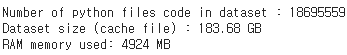

### 스트리밍  
일부 엄청 큰 데이터셋은표죽적인 하드 드라이브가 있더라도 다루기 어렵다.  
이 경우 사용하는 서버의 용량을 늘리는 대신 스트리밍 기법을 사용한다.  
스트리밍 모드는 압축된 JSON 파일을 열어 동적으로 읽는다.  
데이터셋은 이제 IterableDataset 객체이다. idx로 원소에 접근 할 수 없지만  
next()를 사용해서 순서대로 접근해야 한다.  


In [3]:
!pip install --quiet datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [4]:
from datasets import load_dataset, DownloadConfig
remote_dataset = load_dataset('transformersbook/codeparrot', split="train",
                              streaming=True)
#엄~~청 큰 데이터를 이렇게 허깅페이스 스트리밍을 사용해 가져올 수 있음
#이 데이터 셋을 훈련,검증으로 나눠 허깅페이스 허브에 업로드하고 스트리밍으로 사용한다.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

### 허깅페이스 허브에 데이터셋 추가하기  
허브에 업로드하면 다음 작업이 가능해진다.  
* 훈련 서버에서 쉽게 다운로드한다.
* 스트리밍 데이터셋을 허브 데이터셋과 함께 사용한다.
* 이 책의 독자는 물론 커뮤니티와 공유한다.  


In [8]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [30]:
!huggingface-cli repo create --type dataset codeparrot-train
!huggingface-cli repo create --type dataset codeparrot-valid

git version 2.34.1
git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

You are about to create datasets/kwkwkwkwpark/codeparrot-train
Proceed? [Y/n] Y

Your repo now lives at:
  https://huggingface.co/datasets/kwkwkwkwpark/codeparrot-train

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/datasets/kwkwkwkwpark/codeparrot-train

git version 2.34.1
git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

You are about to create datasets/kwkwkwkwpark/codeparrot-valid
Proceed? [Y/n] Y

Your repo now lives at:
  https://huggingface.co/datasets/kwkwkwkwpark/codeparrot-valid

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/datasets/kwkwkwkwpark/codeparrot-valid



In [31]:
! git clone https://huggingface.co/datasets/transformersbook/codeparrot-train
! git clone https://huggingface.co/datasets/transformersbook/codeparrot-valid

fatal: destination path 'codeparrot-train' already exists and is not an empty directory.
Cloning into 'codeparrot-valid'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15 (from 1)
Unpacking objects: 100% (15/15), 1.73 KiB | 591.00 KiB/s, done.


In [34]:
!cd codeparrot-train
/content/codeparrot-train
!cp ../codeparrot/*.json.gz .
!rm ./file-000000000183.json.gz

cp: cannot stat '../codeparrot/*.json.gz': No such file or directory
rm: cannot remove './file-000000000183.json.gz': No such file or directory


아니 위에 부분 도대체 왜 안되는지 모르겠음  
!cp ../codeparrot/*.json.gz . 이 명령어가 문제인거 같은데  
내 생각으로는 데이터를 직접 다운 받은걸 기준으로 데이터를 다루는건가 싶음  
***
코랩 기준으로 왼쪽에 폴더를 클릭하면 위에서 git clone에서 복사한 파일들이 다 보임  
여기서 cd를 통해 train으로 가고 그 안에 있는 걸 복사한다는 의미 같은데  
아마 코랩이라서 git push가 제대로 동작안하고 cp도 이상하게 작동하는거 같음  
그래서 일단 이 코드도 패스  
대신 책에서 제공한 주소로 데이터셋 사용하기  
https://huggingface.co/datasets/transformersbook/codeparrot-train  
https://huggingface.co/datasets/transformersbook/codeparrot-valid  
https://huggingface.co/datasets/transformersbook/codeparrot  



## 토크나이저 구축하기  
지금까지는 모델에서 제공하는 토크나이저를 사용했다.  
해당 토크나이저에 정의된 특별한 전처리 파이프라인을 통과한 데이터로 모델을 학습했으니 당연하다.  
사전 훈련된 모델을 사용할 때는 사전 훈련을 위해 선택한 전처리 방식을 **동일하게** 고수하는 것이 중요하다.  
새로운 모델을 훈련할 때는 다른 데이터셋을 위해 준비된 토크나이저를 사용하는 방법이 최적이 아닐 수 있다.
* T5 토크나이저는 C4를 기반으로 훈련되었지만 필터링 때문에 'sex'같은 평범한 단어를 모른다.  
* CamemBERT 토크나이저는 OSCAR 말뭉치의 프랑스어 서브셋으로 훈련했다. 따라서 'being'같은 단어를 모른다.  



In [35]:
from transformers import AutoTokenizer

def tok_list(tokenizer, string):
    input_ids = tokenizer(string, add_special_tokens=False)["input_ids"]
    return [tokenizer.decode(tok) for tok in input_ids]

tokenizer_T5 = AutoTokenizer.from_pretrained("t5-base")
tokenizer_camembert = AutoTokenizer.from_pretrained("camembert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

In [36]:
print(f'"sex"에 대한 T5 토큰: {tok_list(tokenizer_T5,"sex")}')
print(f'"being"에 대한 CamemBERT 토큰: {tok_list(tokenizer_camembert,"being")}')

"sex"에 대한 T5 토큰: ['', 's', 'ex']
"being"에 대한 CamemBERT 토큰: ['be', 'ing']


이렇게 평범하고 짧은 단어를 여러개로 나눠버리면 비효율적이다.  
그래서 토크나이저를 훈련하는 데 사용한 데이터셋의 도메인과 전처리 방식을 이해하는 것이 필요하다.  
토크나이저와 모델은 데이터셋의 편향을 인코딩할 수 있는데 이는 모델의 후속행동에 영향을 미친다.  
따라서 데이터셋에 맞는 최적의 토크나이저를 얻으려면 토크나이저를 직접 훈련해야 한다.  
***
## 토크나이저 모델  
4장에서 공부 했듯이, 토크나이저는 정규화, 사전 토큰화, 토크나이저 모델, 사후 처리로 구성된 전처리 파이프 라인이다.  
2장에서 언급했듯 BPE,WordPiece, 유니그램 같은 부분단어 토큰화 알고리즘을 사용한다.  

* BPE는 기본 단위의 리스트로 시작해서 가장 자주 함께 등장한 기본 단위를 합쳐  
어휘사전에 추가하는 식으로 점진적으로 새 토큰을 만드는 과정을 거칩니다.  
이 과정은 사전에 정의된 어휘사전 크기에 도달할 때까지 반복한다.  
* 유니그램은 반대이다. 말뭉치에 있는 모든 단어와 가능성 있는 부분단어로 기본 어휘사전을 구성한다.  
그다음 어휘사전의 목표 크기에 도달할 때까지 점진적으로 유용성이 떨어지는 토큰을 삭제하거나 분할한다.  
WordPiece는 유니그램의 전신이며 공식 구현은 공개한 적이 없다.  

전반적으로 한 알고리즘이 다른 알고리즘보다 확실히 뛰어나다고 판별하기 어렵고 상황마다 다르다.  
***
## 토크나이저 성능 측정하기  
